In [22]:
# importing necessary libraries and start a spark session
import numpy as np
import pandas as pd
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.246:7077") \
        .appName("mental_health_analysis")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores",2)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

spark_context = spark_session.sparkContext
# just show errors
spark_context.setLogLevel("ERROR")

In [23]:
# read the dataset from hdfs
data = spark_session.read.json("hdfs://192.168.2.142:9000/user/ubuntu/data/corpus-webis-tldr-17.json")
# print schema
data.printSchema()

root
 |-- author: string (nullable = true)
 |-- body: string (nullable = true)
 |-- content: string (nullable = true)
 |-- content_len: long (nullable = true)
 |-- id: string (nullable = true)
 |-- normalizedBody: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- summary_len: long (nullable = true)
 |-- title: string (nullable = true)



In [3]:
# show the first 10 rows
data.show(10)

+------------------+--------------------+--------------------+-----------+-------+--------------------+--------------------+------------+--------------------+-----------+--------+
|            author|                body|             content|content_len|     id|      normalizedBody|           subreddit|subreddit_id|             summary|summary_len|   title|
+------------------+--------------------+--------------------+-----------+-------+--------------------+--------------------+------------+--------------------+-----------+--------+
|  raysofdarkmatter|I think it should...|I think it should...|        178|c69al3r|I think it should...|                math|    t5_2qh0n|Shifting seasonal...|          8|    NULL|
|           Stork13|Art is about the ...|Art is about the ...|        148|c6a9nxd|Art is about the ...|               funny|    t5_2qh33|Personal opinions...|          4|    NULL|
|     Cloud_dreamer|Ask me what I thi...|Ask me what I thi...|         76|c6acx4l|Ask me what I thi.

In [5]:
# convert spark dataframe to Pandas dataframe to show the dataset in a better format
data_pandas = data.limit(10).toPandas()
display(data_pandas)

,author,body,content,content_len,id,normalizedBody,subreddit,subreddit_id,summary,summary_len,title
0,raysofdarkmatter,I think it should be fixed on either UTC stand...,I think it should be fixed on either UTC stand...,178,c69al3r,I think it should be fixed on either UTC stand...,math,t5_2qh0n,Shifting seasonal time is no longer worth it.,8,None
1,Stork13,Art is about the hardest thing to categorize i...,Art is about the hardest thing to categorize i...,148,c6a9nxd,Art is about the hardest thing to categorize i...,funny,t5_2qh33,Personal opinions 'n shit.,4,None
2,Cloud_dreamer,Ask me what I think about the Wall Street Jour...,Ask me what I think about the Wall Street Jour...,76,c6acx4l,Ask me what I think about the Wall Street Jour...,Borderlands,t5_2r8cd,insults and slack ass insight. \n Wall Street ...,73,None
3,NightlyReaper,"In Mechwarrior Online, I have begun to use a m...","In Mechwarrior Online, I have begun to use a m...",213,c8onqew,"In Mechwarrior Online, I have begun to use a m...",gamingpc,t5_2sq2y,"Yes, Joysticks in modern games have apparently...",19,None
4,NuffZetPand0ra,"You are talking about the Charsi imbue, right?...","You are talking about the Charsi imbue, right?...",404,c6acxvc,"You are talking about the Charsi imbue, right?...",Diablo,t5_2qore,Class only items dropped from high-lvl monsters.,7,D2 help?
5,beatlecreedcabaret,All but one of my nails were in the ballpark o...,All but one of my nails were in the ballpark o...,130,c6ahuc4,All but one of my nails were in the ballpark o...,RedditLaqueristas,t5_2se5q,OPI Nail Envy!,3,None
6,nobodysdiary,I could give a shit about turn by turn directi...,I could give a shit about turn by turn directi...,156,c6aggux,I could give a shit about turn by turn directi...,apple,t5_2qh1f,I don't drive like most people in major citi...,18,None
7,chrom_ed,"So you're saying ""try it, I might not mind los...","So you're saying ""try it, I might not mind los...",134,c6agxtv,"So you're saying ""try it, I might not mind los...",apple,t5_2qh1f,you don't seem to understand what's going on h...,9,None
8,gadzookfilms,I love this idea and most definitely want to h...,I love this idea and most definitely want to h...,126,c6asb7p,I love this idea and most definitely want to h...,RedditFilmsProduction,t5_2v33h,"How we make money? How we involve everyone, yo?",9,None
9,iamacannibal,Theres an entire small town under the lake by ...,Theres an entire small town under the lake by ...,181,c6aveyw,Theres an entire small town under the lake by ...,AbandonedPorn,t5_2sh6t,I'll try and get some similar shots from lake ...,25,None


In [7]:
# print total number of rows
print("The number of total rows of the dataset is: \t", data.count())
# print the number of different subreddits
print("The number of different subreddits is: \t", data.select("subreddit").distinct().count())

The number of total rows of the dataset is: 	 3848330


The number of different subreddits is: 	 29651


In [9]:
# show the top 20 subreddits
top_subreddits = data.groupBy('subreddit').count().orderBy('count', ascending=False)
top_subreddits.show(20)

+-------------------+------+
|          subreddit| count|
+-------------------+------+
|          AskReddit|589947|
|      relationships|352049|
|    leagueoflegends|109307|
|               tifu| 52219|
|relationship_advice| 50416|
|              trees| 47286|
|             gaming| 43851|
|            atheism| 43268|
|      AdviceAnimals| 40783|
|              funny| 40171|
|           politics| 36518|
|               pics| 35098|
|                sex| 28806|
|                WTF| 25781|
|  explainlikeimfive| 25482|
|      todayilearned| 25004|
|            Fitness| 22694|
|               IAmA| 22689|
|          worldnews| 22577|
|              DotA2| 22405|
+-------------------+------+
only showing top 20 rows



In [36]:
# take a subset of the data
subset_data = data.limit(100000)
subset_data.show(10)

+------------------+--------------------+--------------------+-----------+-------+--------------------+--------------------+------------+--------------------+-----------+--------+
|            author|                body|             content|content_len|     id|      normalizedBody|           subreddit|subreddit_id|             summary|summary_len|   title|
+------------------+--------------------+--------------------+-----------+-------+--------------------+--------------------+------------+--------------------+-----------+--------+
|  raysofdarkmatter|I think it should...|I think it should...|        178|c69al3r|I think it should...|                math|    t5_2qh0n|Shifting seasonal...|          8|    NULL|
|           Stork13|Art is about the ...|Art is about the ...|        148|c6a9nxd|Art is about the ...|               funny|    t5_2qh33|Personal opinions...|          4|    NULL|
|     Cloud_dreamer|Ask me what I thi...|Ask me what I thi...|         76|c6acx4l|Ask me what I thi.

In [34]:
subset_data.count()

50000

In [31]:
from pyspark.sql.functions import col

# defining keywords related to mental health, in tuple format
keywords = [
    'anxiety', 'panic', 'phobia', 
    'depression', 'bipolar', 'moodswings', 'mood_swings',
    'schizophrenia', 'delusions', 'hallucinations',
    'anorexia', 'bulimia', 'binge eating', 'binge_eating', 'addiction', 
    'obsessivecompulsivedisorder', 'obsessive_compulsive_disorder',
    'OCD', 'borderline', 'antisocial', 
    'obsessive', 'compulsive', 'narcissistic',
    'PTSD', 'trauma', 'stress',
    'dissociative identity', 'dissociative_identity', 'amnesia',
    'psychotic', 'depressive', 'suicide',
    'mentalhealth', 'mental_health',
]

In [37]:
from pyspark.sql.functions import lower, trim

# preprocess subreddit column
subset_data = subset_data.withColumn('subreddit', lower(trim(col('subreddit'))))

# convert keywords to DataFrame
keywords_df = spark_session.createDataFrame([(k,) for k in keywords], ['keyword'])

# Filter data using isin() function
keyword_counts_data = subset_data.filter(lower(col('subreddit')).isin(keywords)).\
                        groupBy('subreddit').count().\
                        join(keywords_df, lower(col('subreddit')) == col('keyword'), 'right').\
                        select('keyword', 'count').\
                        orderBy('count', ascending=False)

keyword_counts_data.show()

+--------------------+-----+
|             keyword|count|
+--------------------+-----+
|          depression|   74|
|             anxiety|   34|
|             bipolar|   23|
|        mentalhealth|    4|
|       schizophrenia|    3|
|           addiction|    1|
|             amnesia|    1|
|           delusions| NULL|
|obsessive_compuls...| NULL|
|      hallucinations| NULL|
|              trauma| NULL|
|            anorexia| NULL|
|               panic| NULL|
|             bulimia| NULL|
|              stress| NULL|
|        binge eating| NULL|
|                 OCD| NULL|
|        binge_eating| NULL|
|dissociative iden...| NULL|
|obsessivecompulsi...| NULL|
+--------------------+-----+
only showing top 20 rows



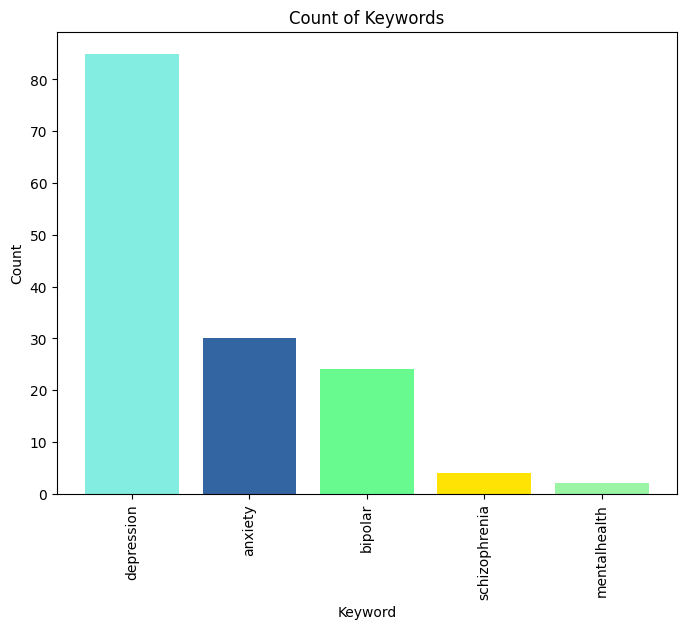

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# convert PySpark dataframe to pandas datafraame
keyword_counts_pandas = keyword_counts_data.toPandas()

# generate random colors for each keyword
total_keywords = len(keyword_counts_pandas)
colors_list = np.random.rand(total_keywords, 3)  # Generate random RGB colors

plt.figure(figsize=(8, 6))
plt.bar(keyword_counts_pandas['keyword'], keyword_counts_pandas['count'], color=colors_list)
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.title('Count of Keywords')
plt.xticks(rotation=90)
plt.show()
